# Распознавание звука

## Импорт библиотек

In [1]:
import sys 
import os 

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import classification_report

import tensorflow as tf 
from tensorflow import keras
 
from IPython import display 

In [2]:
sys.path.append('D:/Programming/Python')

In [3]:
from tools import show_correlation, export2, rounding
from decorators import timeit
from ml_tools import training_plot, predictions_plot

# Импорт данных

In [4]:
os.listdir()

['commands', 'commands_recognition.ipynb', '.git']

In [5]:
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory( 
    directory='commands', 
    batch_size=16, 
    validation_split=0.2, 
    output_sequence_length=16_000, 
    seed=0, 
    subset='both') 

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [6]:
label_names = training_set.class_names
print("label names:", label_names)

label names: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


## Обработка данных

- Каждый файл WAV содержит данные временных рядов с заданным количеством выборок в секунду.
- Каждый образец представляет собой амплитуду звукового сигнала в это конкретное время.
- В 16-битной системе, такой как WAV-файлы в мини-наборе данных "Commands", значения амплитуд находятся в диапазоне от -32 768 до 32 767.
- Частота дискретизации для этого набора данных составляет 16 кГц.

In [7]:
def decode_audio(audio_binary):
  """Decode wav audio"""
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return audio

In [8]:
def squeeze(audio, labels): 
  '''transform to mono audio'''
  audio = tf.squeeze(audio, axis=-1) 
  return audio, labels 

In [9]:
training_set = training_set.map(squeeze, tf.data.AUTOTUNE) 
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [10]:
audio, label = next(iter(training_set)) 
display.display(display.Audio(audio[0], rate=16000))

## Визуализация

In [11]:
def plot_wave(waveform, label): 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.plot(waveform) 
    plt.xlim([0, 16000]) 
    plt.ylim([-1, 1]) 
    plt.xlabel('Time') 
    plt.ylabel('Amplitude') 
    plt.grid(True) 
    plt.show()

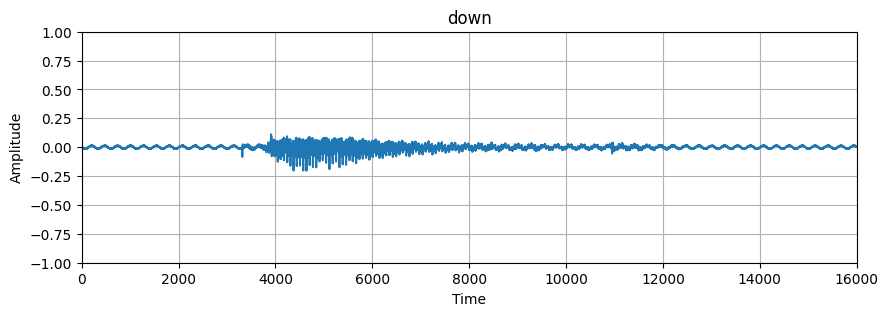

In [12]:
plot_wave(audio[0], label_names[label[0]]) 

In [13]:
def get_spectrogram(waveform): 
    '''Convert waveform to spectrogram '''
    # кратковременное преобразование Фурье STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram) 
    return spectrogram[..., tf.newaxis] 

In [14]:
def plot_spectrogram(spectrogram, label): 
    spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.imshow(log_spec, aspect='auto', origin='lower') 
    plt.colorbar(format='%+2.0f dB') 
    plt.xlabel('Time') 
    plt.ylabel('Frequency') 
    plt.show()

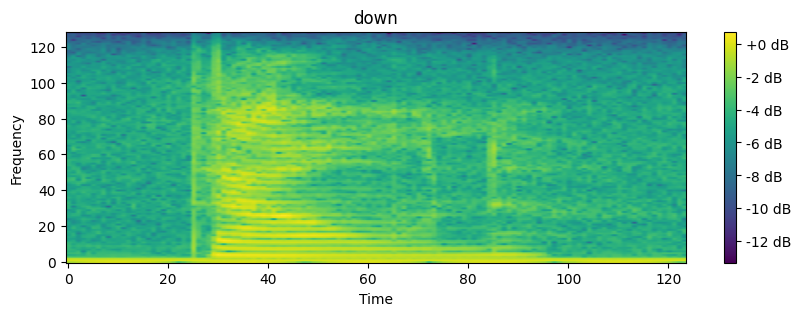

In [15]:
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])

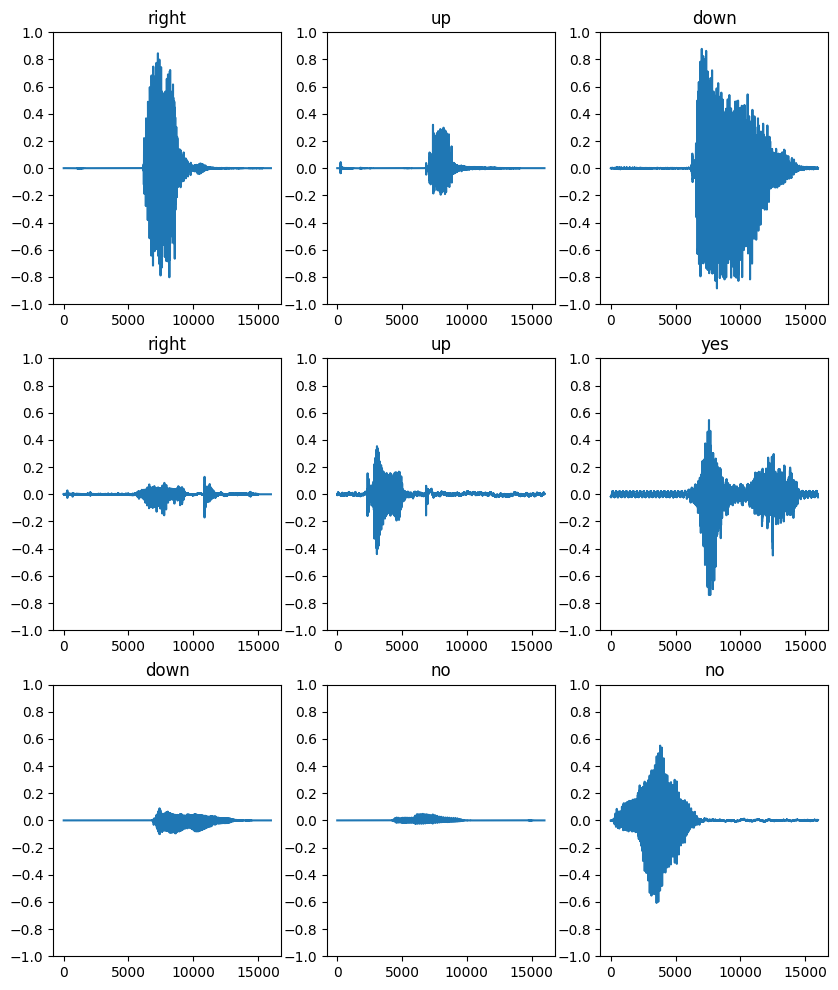

In [18]:
rows, cols = 3, 3

audio, label = next(iter(training_set))

fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(zip(audio, label)):
  if i == rows * cols: break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio)
  ax.set_yticks(np.linspace(-1, 1, 10+1))
  label = label_names[label]
  ax.set_title(label)

plt.show()

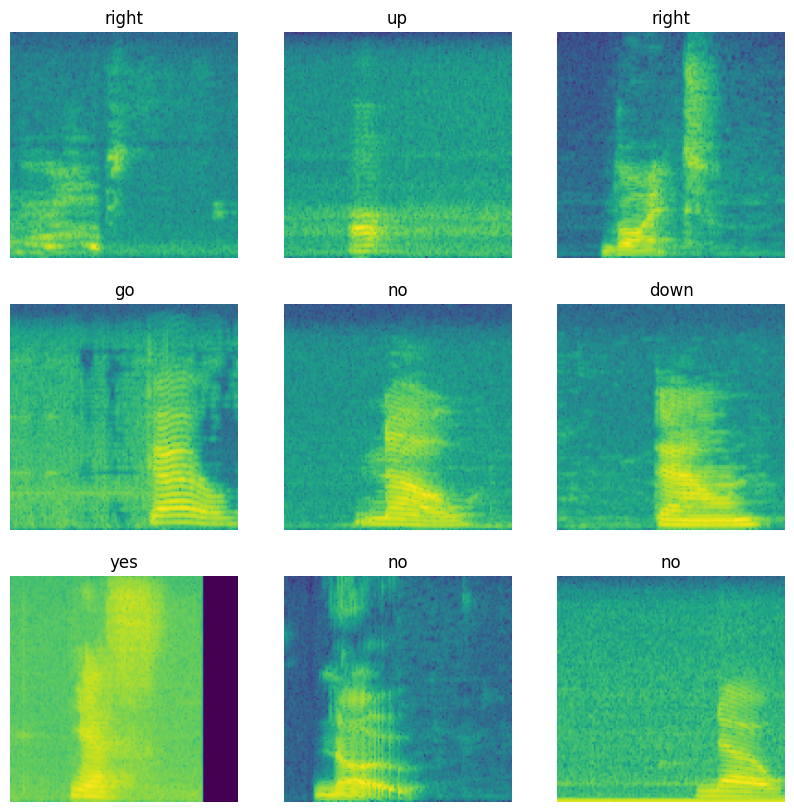

In [26]:
rows, cols = 3, 3

audio, label = next(iter(training_set))

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (audio, label) in enumerate(zip(audio, label)):
    if i == rows * cols: break
    spectrogram = get_spectrogram(audio) 
    spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
    r = i // cols
    c = i % cols  
    ax = axes[r][c]
    ax.imshow(log_spec, aspect='auto', origin='lower') 
    label = label_names[label]
    ax.set_title(label)
    ax.axis('off')

plt.show()

## Преобразование аудио в изображение спектограммы

In [ ]:
def get_spectrogram_dataset(dataset): 
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE) 
    return dataset

## Разделение данных

In [ ]:
#train_text_split

train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 
  
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

Проврека размерности

In [ ]:
train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 
  
print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


## Построение модели

In [ ]:
def get_model(input_shape, num_labels): 

    model = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=input_shape), 

        tf.keras.layers.Resizing(64, 64), 
        tf.keras.layers.Normalization(), 
          
        tf.keras.layers.Conv2D(64, 3, activation='relu'), 
        tf.keras.layers.Conv2D(128, 3, activation='relu'), 
        tf.keras.layers.MaxPooling2D(), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Flatten(), 
          
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.5), 
          
        tf.keras.layers.Dense(num_labels, activation='softmax') 
    ]) 
    model.summary() 
    return model 

In [ ]:
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 
  
model = get_model(input_shape, num_labels)

Input shape: (124, 129, 1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_5 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 30, 30, 128)      

In [ ]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'] 
) 

## Обучение модели

In [ ]:
epochs = 10
verbose = True

monitor = 'loss'
min_delta = 0.01
patience = 5

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose)]

In [ ]:
history = model.fit( 
    train_set, 
    validation_data=val_set, 
    epochs=epochs, 
)

400/400 [==============================] - 98s 244ms/step - loss: 1.4241 - accuracy: 0.5197 - val_loss: 0.9136 - val_accuracy: 0.7163


D:\Programming/Python\ml_tools.py:44: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, max(history.epoch))


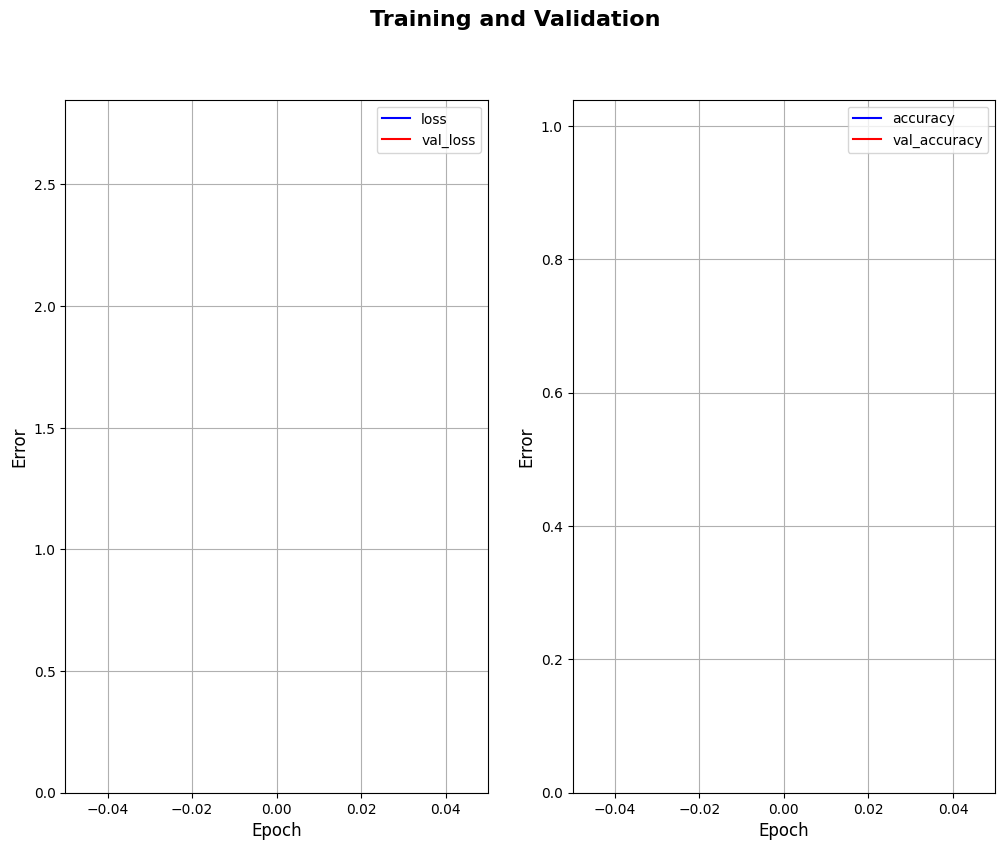

In [ ]:
training_plot(history)

## Оценка модели

Матрица путаницы

50/50 [==============================] - 2s 34ms/step


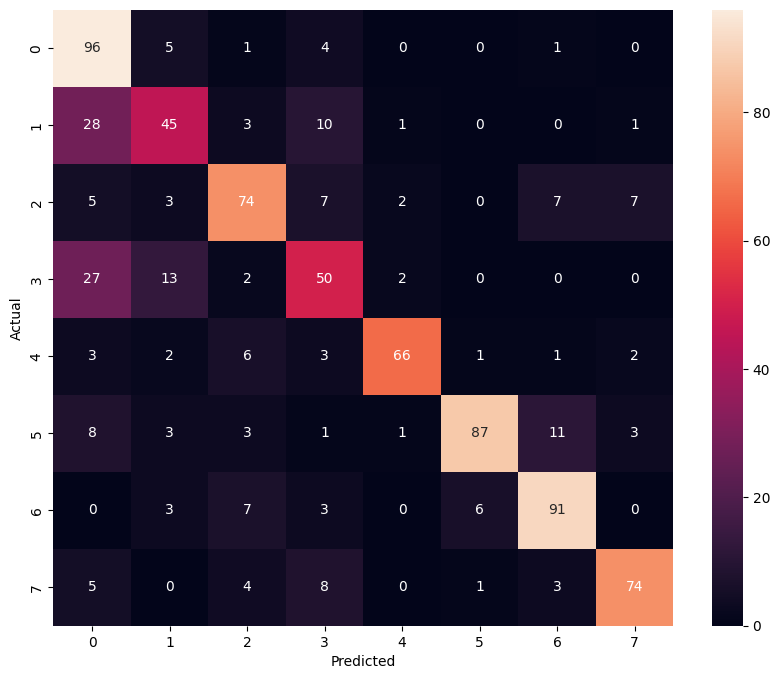

In [ ]:
y_pred = np.argmax(model.predict(test_set), axis=1) 
y_true = np.concatenate([y for x, y in test_set], axis=0) 
cm = tf.math.confusion_matrix(y_true, y_pred) 
  
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

Классификационный отчет

In [ ]:
report = classification_report(y_true, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.56      0.90      0.69       107
           1       0.61      0.51      0.56        88
           2       0.74      0.70      0.72       105
           3       0.58      0.53      0.56        94
           4       0.92      0.79      0.85        84
           5       0.92      0.74      0.82       117
           6       0.80      0.83      0.81       110
           7       0.85      0.78      0.81        95

    accuracy                           0.73       800
   macro avg       0.75      0.72      0.73       800
weighted avg       0.75      0.73      0.73       800



## Тестирование

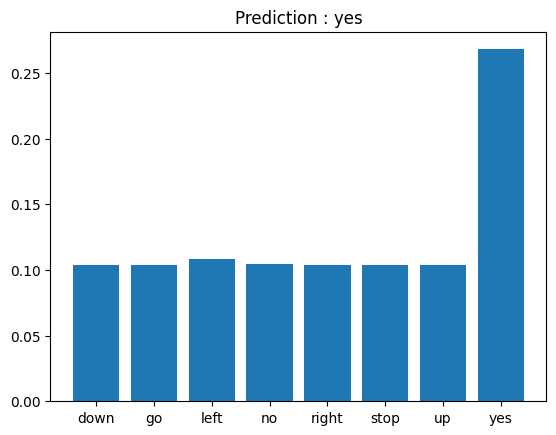

In [ ]:
path = 'commands/yes/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path)) 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,) 
audio, labels = squeeze(x, 'yes') 
  
waveform = audio 
display.display(display.Audio(waveform, rate=16000)) 
  
x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 
  
prediction = model(x) 
plt.bar(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()